# Задача 1
Пытаемся предугадать преступление, зная день недели, время суток и район, где оно было совершено

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
%matplotlib inline

In [2]:
# Путь к датасету надо ввести свой
data = pd.read_csv('d:\\Dataset\\police-department-incidents.csv', sep = ',', engine = 'python')

In [3]:
data

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,50436712,ASSAULT,BATTERY,Wednesday,2005-04-20T00:00:00,04:00,MISSION,NONE,18TH ST / CASTRO ST,-122.435003,37.760888,"{'human_address': '{""address"":"""",""city"":"""",""st...",5043671204134
1,80049078,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Sunday,2008-01-13T00:00:00,18:00,PARK,NONE,1100 Block of CLAYTON ST,-122.446838,37.762255,"{'human_address': '{""address"":"""",""city"":"""",""st...",8004907806304
2,130366639,ASSAULT,AGGRAVATED ASSAULT WITH A KNIFE,Sunday,2013-05-05T00:00:00,04:10,INGLESIDE,"ARREST, BOOKED",0 Block of SGTJOHNVYOUNG LN,-122.444707,37.724931,"{'human_address': '{""address"":"""",""city"":"""",""st...",13036663904012
3,30810835,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Tuesday,2003-07-08T00:00:00,01:00,SOUTHERN,"ARREST, BOOKED",MASON ST / TURK ST,-122.408954,37.783288,"{'human_address': '{""address"":"""",""city"":"""",""st...",3081083565050
4,130839567,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Friday,2013-10-04T00:00:00,20:53,TENDERLOIN,"ARREST, BOOKED",TURK ST / LEAVENWORTH ST,-122.414056,37.782793,"{'human_address': '{""address"":"""",""city"":"""",""st...",13083956765010
5,70838580,BURGLARY,"BURGLARY OF APARTMENT HOUSE, UNLAWFUL ENTRY",Tuesday,2007-08-14T00:00:00,07:00,NORTHERN,NONE,3100 Block of FRANKLIN ST,-122.426731,37.803467,"{'human_address': '{""address"":"""",""city"":"""",""st...",7083858005013
6,80233102,DRUG/NARCOTIC,POSSESSION OF MARIJUANA,Tuesday,2008-03-04T00:00:00,14:23,INGLESIDE,"ARREST, CITED",MISSION ST / PERSIA AV,-122.435977,37.723129,"{'human_address': '{""address"":"""",""city"":"""",""st...",8023310216010
7,60711805,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,2006-07-05T00:00:00,15:50,INGLESIDE,"ARREST, CITED",2300 Block of SAN JOSE AV,-122.447241,37.720158,"{'human_address': '{""address"":"""",""city"":"""",""st...",6071180565016
8,40062593,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Wednesday,2003-12-10T00:00:00,09:30,INGLESIDE,NONE,0 Block of MOFFITT ST,-122.432788,37.737157,"{'human_address': '{""address"":"""",""city"":"""",""st...",4006259306304
9,110051822,NON-CRIMINAL,"STAY AWAY OR COURT ORDER, NON-DV RELATED",Monday,2011-01-17T00:00:00,15:35,INGLESIDE,NONE,600 Block of CAMPBELL AV,-122.408761,37.715900,"{'human_address': '{""address"":"""",""city"":"""",""st...",11005182271024


- `IncidntNum` - айди инцидента
- `Category` - категория инцидента
- `Descript` - краткое описание инцидента
- `DayOfWeek` - день недели, когда инцидент произошел
- `Date` - полная дата происшествия
- `Time` - время происшествия
- `PdDistrict` - район, в котором случился инцидент
- `Resolution` - результат выезда полиции
- `Address` - адрес происшествия
- `X` - координаты долготы
- `Y` - координаты широты
- `Location` - предыдущие три столбца в одном объекте
- `PdId` - айди в общей базе полиции

In [4]:
print(data.shape)
print(data.columns)

(2215024, 13)
Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'],
      dtype='object')


In [5]:
# Категорий преступлений очень много, поэтому оставим 4 самые интересные категории
data = data.query("Category not in ['OTHER OFFENSES','NON-CRIMINAL','LIQUOR LAWS', 'WARRANTS', 'MISSING PERSON', 'FRAUD', 'SUSPICIOUS OCC'\
                  'SECONDARY CODES', 'RECOVERED VEHICLE',  'EMBEZZLEMENT', 'BRIBERY', 'GAMBLING', 'TREA', 'PORNOGRAPHY/OBSCENE MAT',\
                  'WEAPON LAWS', 'FORGERY/COUNTERFEITING', 'TRESPASS', 'STOLEN PROPERTY', 'FAMILY OFFENSES', 'DRUNKENNESS',\
                  'RUNAWAY', 'EXTORTION', 'BAD CHECKS', 'VEHICLE THEFT', 'SUICIDE', 'SUSPICIOUS OCC', 'ARSON', 'SEX OFFENSES, FORCIBLE',\
                  'BURGLARY', 'DRIVING UNDER THE INFLUENCE', 'LOITERING','KIDNAPPING', 'SEX OFFENSES, NON FORCIBLE','SECONDARY CODES','DISORDERLY CONDUCT', 'ASSAULT','ROBBERY' ]")
data = data.reset_index(drop=True)

In [6]:
# Категории, которые будем предугадывать
data['Category'].unique()

array(['LARCENY/THEFT', 'DRUG/NARCOTIC', 'VANDALISM', 'PROSTITUTION'],
      dtype=object)

## Давайте уберём бесполезные столбцы такие как: 
* IncidntNum, PdId - это вообще айдишники, точно не нужны
* Resolution, Descript. Descript - это всё равно, что Category, Resolution - под 90% этих преступлений будет ARRESTED, так что выкидываем
* Location, Address. Location - смахивает на json с полями X,Y и нет смысла его парсить, Address - оставим район, потому выкинем адрес

In [7]:
# Потрём столбцы, которые не нужны нам
data = data.drop('IncidntNum', axis = 1).drop('Location', axis = 1).drop('Descript', axis = 1)

data = data.drop('PdId', axis = 1).drop('Resolution', axis = 1).drop('Date', axis = 1).drop('Address', axis = 1)


In [8]:
# Два миллиона записей - это много. Обрежем. Оставим так мало, потому что мой ноут плачет от больших объёмов данных.
data = data.drop(data.index[10000:])
data

,Category,DayOfWeek,Time,PdDistrict,X,Y
0,LARCENY/THEFT,Sunday,18:00,PARK,-122.446838,37.762255
1,DRUG/NARCOTIC,Tuesday,14:23,INGLESIDE,-122.435977,37.723129
2,LARCENY/THEFT,Wednesday,09:30,INGLESIDE,-122.432788,37.737157
3,LARCENY/THEFT,Saturday,22:00,NORTHERN,-122.420815,37.787236
4,LARCENY/THEFT,Sunday,18:00,MISSION,-122.416015,37.755546
5,LARCENY/THEFT,Tuesday,22:00,TARAVAL,-122.508797,37.756259
6,LARCENY/THEFT,Sunday,21:00,INGLESIDE,-122.420132,37.746575
7,LARCENY/THEFT,Wednesday,17:45,RICHMOND,-122.513642,37.778469
8,DRUG/NARCOTIC,Saturday,08:40,TENDERLOIN,-122.415858,37.783051
9,DRUG/NARCOTIC,Wednesday,17:20,SOUTHERN,-122.406941,37.780679


In [9]:
# Время - понятие растяжимое. Сделаем так: [0:00, 7:00) - ночь(0), [7:00, 15:00) - день(1), [15:00, 0:00) - вечер(2).  
temp = data['Time'].str.replace('[:]', '.') 
temp = temp.astype(float)   
for i in range(data['Time'].size):
    if 0.00 <= temp[i] < 7.00:
        data.at[i, 'Time'] = 'Night'
    elif 7.00 <= temp[i] < 15.00:
        data.at[i, 'Time'] = 'Afternoon'
    else:
        data.at[i, 'Time'] = 'Evening'


In [10]:
#data = data.reset_index(drop=True)
data

,Category,DayOfWeek,Time,PdDistrict,X,Y
0,LARCENY/THEFT,Sunday,Evening,PARK,-122.446838,37.762255
1,DRUG/NARCOTIC,Tuesday,Afternoon,INGLESIDE,-122.435977,37.723129
2,LARCENY/THEFT,Wednesday,Afternoon,INGLESIDE,-122.432788,37.737157
3,LARCENY/THEFT,Saturday,Evening,NORTHERN,-122.420815,37.787236
4,LARCENY/THEFT,Sunday,Evening,MISSION,-122.416015,37.755546
5,LARCENY/THEFT,Tuesday,Evening,TARAVAL,-122.508797,37.756259
6,LARCENY/THEFT,Sunday,Evening,INGLESIDE,-122.420132,37.746575
7,LARCENY/THEFT,Wednesday,Evening,RICHMOND,-122.513642,37.778469
8,DRUG/NARCOTIC,Saturday,Afternoon,TENDERLOIN,-122.415858,37.783051
9,DRUG/NARCOTIC,Wednesday,Evening,SOUTHERN,-122.406941,37.780679


In [11]:
data.describe()
# Уже отсюда видно, что в южном районе кражи в пятницу вечером - обычное явление

,X,Y
count,10000.000000,10000.000000
mean,-122.421863,37.771453
std,0.023948,0.022099
min,-122.513642,37.708154
25%,-122.430201,37.761768
50%,-122.416075,37.778469
75%,-122.407244,37.785560
max,-122.364937,37.819975


In [12]:
# Работаем с данными. Далее векторизация и нормализация
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['Category', 'DayOfWeek', 'Time', 'PdDistrict']
['X', 'Y']


In [13]:
data_describe = data.describe(include = [object])
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

[] ['Category', 'DayOfWeek', 'Time', 'PdDistrict']


In [14]:

data['DayOfWeek'].unique()

array(['Sunday', 'Tuesday', 'Wednesday', 'Saturday', 'Thursday', 'Friday',
       'Monday'], dtype=object)

In [15]:
data_nonbinary = pd.get_dummies(data[['PdDistrict', 'DayOfWeek', 'Time']])
print(data_nonbinary.columns)

Index(['PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL', 'PdDistrict_INGLESIDE',
       'PdDistrict_MISSION', 'PdDistrict_NORTHERN', 'PdDistrict_PARK',
       'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN', 'PdDistrict_TARAVAL',
       'PdDistrict_TENDERLOIN', 'DayOfWeek_Friday', 'DayOfWeek_Monday',
       'DayOfWeek_Saturday', 'DayOfWeek_Sunday', 'DayOfWeek_Thursday',
       'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday', 'Time_Afternoon',
       'Time_Evening', 'Time_Night'],
      dtype='object')


In [16]:
data_numerical = data[numerical_columns]
data_numerical.describe()

,X,Y
count,10000.000000,10000.000000
mean,-122.421863,37.771453
std,0.023948,0.022099
min,-122.513642,37.708154
25%,-122.430201,37.761768
50%,-122.416075,37.778469
75%,-122.407244,37.785560
max,-122.364937,37.819975


In [17]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [18]:
data_numerical.describe()

,X,Y
count,1.000000e+04,1.000000e+04
mean,-3.909115e-12,-1.355312e-11
std,1.000000e+00,1.000000e+00
min,-3.832526e+00,-2.864369e+00
25%,-3.481754e-01,-4.382858e-01
50%,2.416677e-01,3.174709e-01
75%,6.104408e-01,6.383332e-01
max,2.377079e+00,2.195664e+00


In [19]:
data_new = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)

(10000, 6)


In [20]:
# Готовим выборки для обучения
X = data_new 
y = data['Category']
feature_names = X.columns


In [21]:
feature_names

Index(['X', 'Y', 'PdDistrict_BAYVIEW', 'PdDistrict_CENTRAL',
       'PdDistrict_INGLESIDE', 'PdDistrict_MISSION', 'PdDistrict_NORTHERN',
       'PdDistrict_PARK', 'PdDistrict_RICHMOND', 'PdDistrict_SOUTHERN',
       'PdDistrict_TARAVAL', 'PdDistrict_TENDERLOIN', 'DayOfWeek_Friday',
       'DayOfWeek_Monday', 'DayOfWeek_Saturday', 'DayOfWeek_Sunday',
       'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday',
       'Time_Afternoon', 'Time_Evening', 'Time_Night'],
      dtype='object')

In [22]:
#lab_enc = preprocessing.LabelEncoder()
#training_scores_encoded = lab_enc.fit_transform(y)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

7000 3000


## kNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 11, n_jobs = -1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform')

In [25]:
y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)

print(err_train, err_test)

0.29728571428571426 0.3363333333333333


## Как видно, ошибка вообще достаточно высокая. Имеется небольшое переобучение

# Метод ближайших соседей с подгоном параметра

In [26]:
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 10, 15, 20, 25, 35, 45, 55]
knn = KNeighborsClassifier(algorithm = 'kd_tree',n_jobs = -1)
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10, n_jobs = -1)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.33899999999999997 10


In [33]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors, n_jobs = -1,algorithm = 'kd_tree').fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print(err_train, err_test)

0.2948571428571429 0.3363333333333333


## Результат всё так же печален. Было бы замечательно проверить всё на больших объёмах данных, но моя машина не настолько производительна и просто перегревается и уходит в ребут :(

# Задача 2

## Обучаем нейросеть, делаем выводы

In [62]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs', 
                          activation = 'tanh', random_state = 42)
mlp_model.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

# Насколько всё хорошо?

In [63]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [64]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.2887142857142857 0.3273333333333333


In [65]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))

0.7112857142857143 0.6726666666666666


## Всё примерно настолько же плохо. 

## Подбор гиперпараметров
Подберем оптимальное значение параметра регуляризации alpha

In [66]:

alpha_arr = np.logspace(-3, 2, 40)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'tanh', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

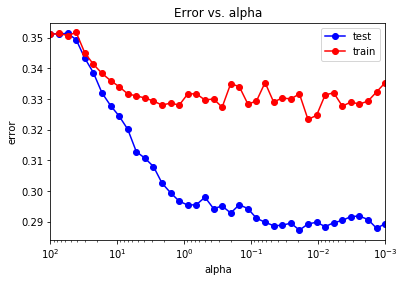

In [67]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

In [68]:
# Мин. значение ошибки
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.2872857142857143 0.3233333333333333


In [69]:
# Получим оптимальное значение параметра регуляризации alpha:

In [70]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.01425103]


In [71]:
alpha_opt = alpha_opt[0]

In [72]:
# Рассмотрим классификатор с оптимальным параметром. Для этого повторим обучение и посмотрим на ошибку.

In [76]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'tanh', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.2892857142857143
0.3233333333333333


## И снова плохо

## Рассмотрим метрики качества

Матрица рассогласования

In [77]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[ 292  135   25   51]
 [ 244 1657   17  376]
 [  11   21   53   12]
 [  17   60    1   28]]


In [78]:
# Другие метрики

In [79]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

DRUG/NARCOTIC       0.58      0.52      0.55       564
LARCENY/THEFT       0.72      0.88      0.80      1873
 PROSTITUTION       0.55      0.55      0.55        96
    VANDALISM       0.26      0.06      0.10       467

  avg / total       0.62      0.68      0.63      3000



# Выводы

Ошибка всё равно достаточно высока. Вероятно, преступления - это не та категория событий, которую можно предугатать очень хорошо, поскольку влияние человеческого фактора здесь высоко. 
Не всё так плохо, сеть находит связи, например, что преступления с кражами происходят обычно вечером. И обычно ближе к выходным

# Задача 3
## Обучение Random Forest, Extremely Random Forest, Adaboost, Gradient Boosted Tree

## Random Forest

In [80]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [81]:
err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print("Ошибка на обучающей выборке: ", err_train)
print("Ошибка на тестовой выборке: ", err_test)

Ошибка на обучающей выборке:  0.027142857142857142
Ошибка на тестовой выборке:  0.3466666666666667


Результаты неутешительны. Переобучение.

In [82]:
tree_arr = np.arange(10, 100, 5)
test_err = []
train_err = []
oob_err = []

for tree in tree_arr:
    rf = ensemble.RandomForestClassifier(n_estimators = tree, oob_score = True)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    oob_err.append(1 - rf.oob_score_)

D:\PF\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\PF\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\PF\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\PF\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


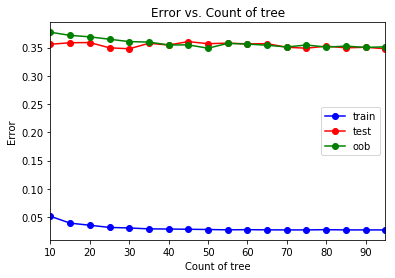

In [83]:
plt.plot(tree_arr, train_err, 'b-o', label = 'train')
plt.plot(tree_arr, test_err, 'r-o', label = 'test')
plt.plot(tree_arr, oob_err, 'g-o', label = 'oob')
plt.xlim([np.min(tree_arr), np.max(tree_arr)])
plt.title('Error vs. Count of tree')
plt.xlabel('Count of tree')
plt.ylabel('Error')
plt.legend()
pass

## Extremely Random Forest

In [84]:
from sklearn import ensemble
ert = ensemble.ExtraTreesClassifier(n_estimators = 100)
ert.fit(X_train, y_train)

err_train = np.mean(y_train != ert.predict(X_train))
err_test  = np.mean(y_test  != ert.predict(X_test))

print(err_train, err_test)

0.027 0.37


## Тут даже ещё хуже стало. Попробуем подобрать количество деревьев?

In [85]:
tree_arr = np.arange(10, 100, 5)
test_err = []
train_err = []
oob_err = []

for tree in tree_arr:
    rf = ensemble.ExtraTreesClassifier(n_estimators = tree, oob_score = True, bootstrap=True)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    oob_err.append(1 - rf.oob_score_)

D:\PF\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\PF\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
D:\PF\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\PF\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


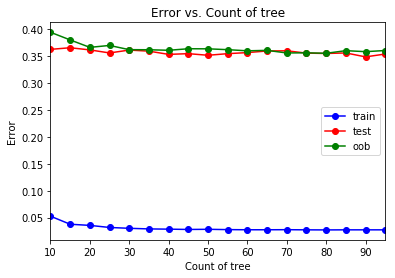

In [86]:
plt.plot(tree_arr, train_err, 'b-o', label = 'train')
plt.plot(tree_arr, test_err, 'r-o', label = 'test')
plt.plot(tree_arr, oob_err, 'g-o', label = 'oob')
plt.xlim([np.min(tree_arr), np.max(tree_arr)])
plt.title('Error vs. Count of tree')
plt.xlabel('Count of tree')
plt.ylabel('Error')
plt.legend()
pass

## Как видно, примерно на 32 деревьях можно добиться прежних результатов. Однако мы жестоко страдаем от переобучения

# AdaBoost

In [87]:
ab = ensemble.AdaBoostClassifier(n_estimators = 100)
ab.fit(X_train, y_train)

err_train = np.mean(y_train != ab.predict(X_train))
err_test  = np.mean(y_test  != ab.predict(X_test))

print(err_train, err_test)

0.3587142857142857 0.36


## Переобучения почти нет, но всё также плохо. Взглянем на другие количества деревьев

In [88]:
tree_arr = np.arange(10, 1000, 40)
test_err = []
train_err = []
oob_err = []

for tree in tree_arr:
    rf = ensemble.AdaBoostClassifier(n_estimators = tree)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

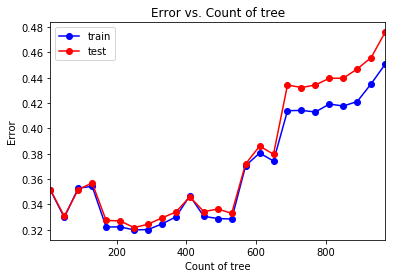

In [89]:
plt.plot(tree_arr, train_err, 'b-o', label = 'train')
plt.plot(tree_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(tree_arr), np.max(tree_arr)])
plt.title('Error vs. Count of tree')
plt.xlabel('Count of tree')
plt.ylabel('Error')
plt.legend()
pass

## Можно получить некоторые улучшений при ~300 деревьях. Переобучения нет или оно крайне мало. Но при ~700 и более деревьях видим переобучение и вообще высокую ошибку. Свойство алгоритма быть устойчивым к переобучению можно считать подтверждённым

# Gradient boosted trees

In [94]:
gbt = ensemble.GradientBoostingClassifier(n_estimators = 100)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test  = np.mean(y_test  != gbt.predict(X_test))

print(err_train, err_test)

0.27285714285714285 0.29933333333333334


## По сравнению с предыдущими алгоритмами, мы получаем небольшой прирост точности и перешагиваем через порог 30%. Попробуем сделать лучше.

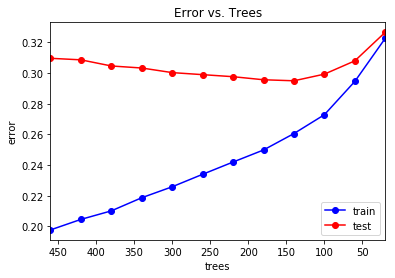

In [95]:
trees_arr = np.arange(20, 500, 40)
test_err = []
train_err = []
for trees in trees_arr:
    gbt = ensemble.GradientBoostingClassifier(n_estimators = trees)
    gbt.fit(X_train, y_train)
    train_err.append(np.mean(y_train != gbt.predict(X_train)))
    test_err.append(np.mean(y_test  != gbt.predict(X_test)))
plt.plot(trees_arr, train_err, 'b-o', label = 'train')
plt.plot(trees_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.max(trees_arr), np.min(trees_arr)])
plt.title('Error vs. Trees')
plt.xlabel('trees')
plt.ylabel('error')
plt.legend()
pass

## Впрочем, сильно улучшить ситуацию не представляется возможным

# Задача 4

## Применим PCA для сокращения размерности пространства признаков. К новым данным применим Gradient Boosted Trees. Построимграфики зависимости ошибки на тестовой и обучающей выборки в зависимости от количества используемых компонент. Найдём наилучшее значение количества используемых главных компонент. 

Построим графики зависимости ошибок от числа компонент

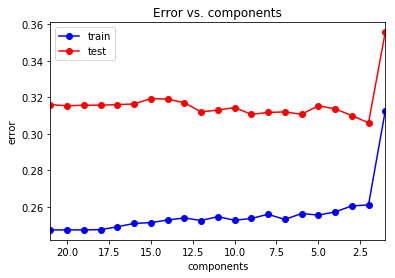

In [106]:
from sklearn import decomposition
components = range(1, 22)
err_test = []
err_train = []
for component in components:
    pca = decomposition.PCA(n_components = component)
    X_train_reduc = pca.fit_transform(X_train)
    X_test_reduc = pca.transform(X_test)
    gbt = ensemble.GradientBoostingClassifier(n_estimators = 150)
    gbt.fit(X_train_reduc, y_train)
    err_train.append(np.mean(y_train.values.ravel() != gbt.predict(X_train_reduc)))
    err_test.append(np.mean(y_test.values.ravel()  != gbt.predict(X_test_reduc)))
    oob_err.append(1 - ert.oob_score)
plt.plot(components, err_train, 'b-o', label = 'train')
plt.plot(components, err_test, 'r-o', label = 'test')
plt.xlim([np.max(components), np.min(components)])
plt.title('Error vs. components')
plt.xlabel('components')
plt.ylabel('error')
plt.legend()
pass


Посмотрим на минимальную ошибку на обучающей и тестовой выборках.

In [108]:
min_train_err = np.min(err_train)
min_test_err = np.min(err_test)
print(min_train_err, min_test_err)

0.24728571428571428 0.306


In [ ]:
Число компонент:

In [109]:
print(err_test.index(np.min(err_test)) + 1)

2


Для того же классификатора ранее мы получили такие ошибки: 0.27285714285714285 0.29933333333333334.
Однако делу это особо не помогло